##Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import numpy as np
from PIL import Image
import pickle

# Define paths
data_dir = "/content/data"  # Replace with your folder path
mss_dir = os.path.join(data_dir, "/content/drive/MyDrive/phase2_data/long")
non_mss_dir = os.path.join(data_dir, "/content/drive/MyDrive/Not unicorn")

# Load images
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = Image.open(img_path).convert("RGB")  # Convert to RGB
        images.append(img)
    return images

# Load MSS and Non-MSS images
mss_images = load_images_from_folder(mss_dir)
non_mss_images = load_images_from_folder(non_mss_dir)

# Create labels
mss_labels = [1] * len(mss_images)  # 1 for MSS
non_mss_labels = [0] * len(non_mss_images)  # 0 for Non-MSS

# Combine data
images = mss_images + non_mss_images
labels = mss_labels + non_mss_labels

# Save loaded dataset
with open("loaded_images.pkl", "wb") as f:
    pickle.dump(images, f)
with open("loaded_labels.pkl", "wb") as f:
    pickle.dump(labels, f)

print("Dataset loaded and saved successfully!")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/phase2_data/long'

## Visualize Raw Images

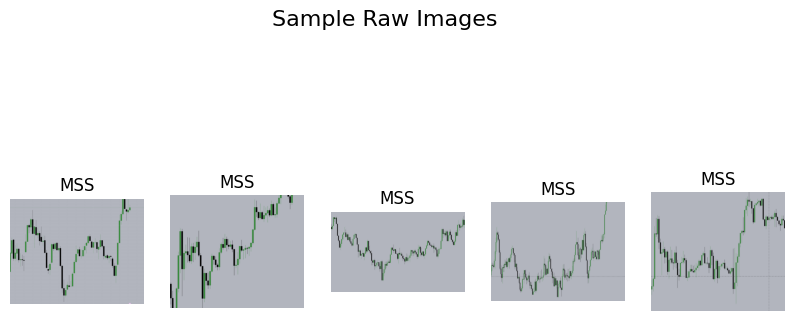

In [ ]:
import matplotlib.pyplot as plt

# Load dataset
with open("loaded_images.pkl", "rb") as f:
    images = pickle.load(f)
with open("loaded_labels.pkl", "rb") as f:
    labels = pickle.load(f)

# Function to plot images
def plot_images(images, labels, title, save_path):
    plt.figure(figsize=(10, 5))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i])
        plt.title("MSS" if labels[i] == 1 else "Non-MSS")
        plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.savefig(save_path)  # Save the plot
    plt.show()

# Plot and save raw images
plot_images(images, labels, "Sample Raw Images", "raw_images_plot.png")

## Split data in  training and testing

In [ ]:
from sklearn.model_selection import train_test_split

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Save split datasets
with open("X_train.pkl", "wb") as f:
    pickle.dump(X_train, f)
with open("X_test.pkl", "wb") as f:
    pickle.dump(X_test, f)
with open("y_train.pkl", "wb") as f:
    pickle.dump(y_train, f)
with open("y_test.pkl", "wb") as f:
    pickle.dump(y_test, f)

print("Dataset split and saved successfully!")
print(f"Training images: {len(X_train)}")
print(f"Testing images: {len(X_test)}")

Dataset split and saved successfully!
Training images: 52
Testing images: 14


##Resize Images

In [ ]:
from PIL import Image
import numpy as np

# Function to resize images
def resize_images(images, size=(224, 224)):
    resized_images = []
    for img in images:
        resized_img = img.resize(size)
        resized_images.append(resized_img)
    return resized_images

# Load split datasets
with open("X_train.pkl", "rb") as f:
    X_train = pickle.load(f)
with open("X_test.pkl", "rb") as f:
    X_test = pickle.load(f)

# Resize images
X_train_resized = resize_images(X_train)
X_test_resized = resize_images(X_test)

# Save resized images
with open("X_train_resized.pkl", "wb") as f:
    pickle.dump(X_train_resized, f)
with open("X_test_resized.pkl", "wb") as f:
    pickle.dump(X_test_resized, f)

print("Images resized and saved successfully!")

Images resized and saved successfully!


##Extract Median Line

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to extract fluctuating median line
def extract_fluctuating_median_line(image):
    # Convert to grayscale
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)

    # Apply thresholding to binarize the image
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a blank image to draw the median line
    median_line_image = np.zeros_like(gray)

    # Draw the median line by connecting the midpoints of each candlestick
    for contour in contours:
        # Get bounding box of the contour
        x, y, w, h = cv2.boundingRect(contour)

        # Calculate the midpoint of the candlestick
        midpoint_x = x + w // 2
        midpoint_y = y + h // 2

        # Draw a circle at the midpoint (for visualization)
        cv2.circle(median_line_image, (midpoint_x, midpoint_y), 2, (255, 255, 255), -1)

    # Connect the midpoints to form the median line
    points = np.column_stack(np.where(median_line_image > 0))
    points = points[np.argsort(points[:, 1])]  # Sort by x-coordinate

    for i in range(len(points) - 1):
        cv2.line(median_line_image, tuple(points[i][::-1]), tuple(points[i+1][::-1]), (255, 255, 255), 1)

    return median_line_image

# Extract fluctuating median lines for training and testing sets
X_train_median = [extract_fluctuating_median_line(img) for img in X_train_resized]
X_test_median = [extract_fluctuating_median_line(img) for img in X_test_resized]

# Save median line images
with open("X_train_median_updated.pkl", "wb") as f:
    pickle.dump(X_train_median, f)
with open("X_test_median_updated.pkl", "wb") as f:
    pickle.dump(X_test_median, f)

print("Fluctuating median lines extracted and saved successfully!")

Fluctuating median lines extracted and saved successfully!


## normalize


In [ ]:
# Function to normalize images
def normalize_images(images):
    normalized_images = []
    for img in images:
        img_array = np.array(img) / 255.0  # Normalize to [0, 1]
        normalized_images.append(img_array)
    return normalized_images

# Normalize images
X_train_normalized = normalize_images(X_train_median)
X_test_normalized = normalize_images(X_test_median)

# Save normalized images
with open("X_train_normalized.pkl", "wb") as f:
    pickle.dump(X_train_normalized, f)
with open("X_test_normalized.pkl", "wb") as f:
    pickle.dump(X_test_normalized, f)

print("Images normalized and saved successfully!")

Images normalized and saved successfully!


##Visualize Preprocessing

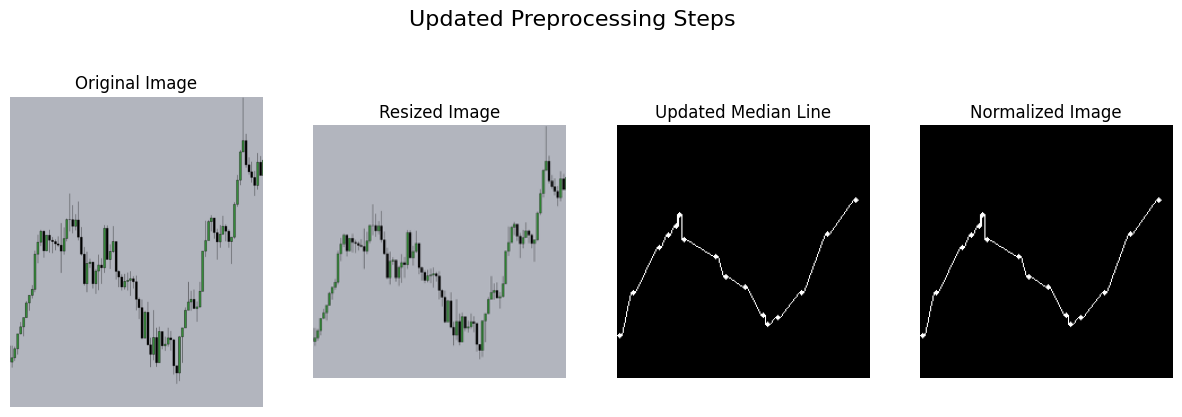

In [ ]:
# Function to visualize updated preprocessing steps
def visualize_updated_preprocessing(original, resized, median, normalized, save_path):
    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 4, 1)
    plt.imshow(original)
    plt.title("Original Image")
    plt.axis("off")

    # Resized Image
    plt.subplot(1, 4, 2)
    plt.imshow(resized)
    plt.title("Resized Image")
    plt.axis("off")

    # Updated Median Line
    plt.subplot(1, 4, 3)
    plt.imshow(median, cmap="gray")
    plt.title("Updated Median Line")
    plt.axis("off")

    # Normalized Image
    plt.subplot(1, 4, 4)
    plt.imshow(normalized, cmap="gray")
    plt.title("Normalized Image")
    plt.axis("off")

    plt.suptitle("Updated Preprocessing Steps", fontsize=16)
    plt.savefig(save_path)  # Save the plot
    plt.show()

# Visualize preprocessing for a sample image
sample_index = 0  # Change this to visualize different images
visualize_updated_preprocessing(
    original=X_train[sample_index],
    resized=X_train_resized[sample_index],
    median=X_train_median[sample_index],
    normalized=X_train_normalized[sample_index],
    save_path="updated_preprocessing_steps.png"
)

In [ ]:
from PIL import Image

# Function to resize and convert images
def preprocess_images(images, size=(64, 64)):
    processed_images = []
    for img in images:
        # Resize image
        img_resized = img.resize(size)

        # Convert to grayscale if necessary
        if img_resized.mode != 'L':
            img_resized = img_resized.convert('L')

        # Convert to numpy array
        img_array = np.array(img_resized)

        # Normalize to range [-1, 1]
        img_array = (img_array / 127.5) - 1

        processed_images.append(img_array)
    return np.array(processed_images)

# Load split datasets
with open("X_train.pkl", "rb") as f:
    X_train = pickle.load(f)
with open("X_test.pkl", "rb") as f:
    X_test = pickle.load(f)

# Preprocess images
X_train_processed = preprocess_images(X_train, size=(64, 64))
X_test_processed = preprocess_images(X_test, size=(64, 64))

# Save processed images
with open("X_train_processed.pkl", "wb") as f:
    pickle.dump(X_train_processed, f)
with open("X_test_processed.pkl", "wb") as f:
    pickle.dump(X_test_processed, f)

print("Images preprocessed and saved successfully!")

Images preprocessed and saved successfully!


In [ ]:
# # Define the generator
# def build_generator():
#     model = tf.keras.Sequential()
#     model.add(Input(shape=(100,)))  # Input noise vector of size 100
#     model.add(layers.Dense(8 * 8 * 256, use_bias=False))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())

#     model.add(layers.Reshape((8, 8, 256)))
#     model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())

#     model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())

#     model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
#     return model

# # Define the discriminator
# def build_discriminator():
#     model = tf.keras.Sequential()
#     model.add(Input(shape=(64, 64, 1)))  # Input image of size (64, 64, 1)
#     model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))

#     model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))

#     model.add(layers.Flatten())
#     model.add(layers.Dense(1))
#     return model

In [ ]:
# # Load processed images
# with open("X_train_processed.pkl", "rb") as f:
#     X_train_processed = pickle.load(f)

# # Add channel dimension (64, 64) -> (64, 64, 1)
# X_train_gan = np.expand_dims(X_train_processed, axis=-1)

# print(f"GAN training dataset shape: {X_train_gan.shape}")

In [ ]:
# # Build and compile the GAN
# generator = build_generator()
# discriminator = build_discriminator()

# discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Combined GAN model
# discriminator.trainable = False
# gan_input = Input(shape=(100,))
# gan_output = discriminator(generator(gan_input))
# gan = tf.keras.Model(gan_input, gan_output)
# gan.compile(optimizer='adam', loss='binary_crossentropy')

# # Training function
# def train_gan(epochs=50, batch_size=128):
#     for epoch in range(epochs):
#         print(f"Epoch {epoch + 1}/{epochs}")

#         # Train discriminator
#         idx = np.random.randint(0, X_train_gan.shape[0], batch_size)
#         real_images = X_train_gan[idx]
#         noise = np.random.normal(0, 1, (batch_size, 100))
#         fake_images = generator.predict(noise)

#         d_loss_real = discriminator.train_on_batch(real_images, np.ones((batch_size, 1)))
#         d_loss_fake = discriminator.train_on_batch(fake_images, np.zeros((batch_size, 1)))
#         d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

#         # Train generator
#         noise = np.random.normal(0, 1, (batch_size, 100))
#         g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

#         print(f"Discriminator loss: {d_loss[0]}, Accuracy: {d_loss[1]}")
#         print(f"Generator loss: {g_loss}")

# # Train the GAN
# train_gan(epochs=50, batch_size=128)

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input  # Import Input layer
import numpy as np
import pickle

# Define the generator
def build_generator():
    model = tf.keras.Sequential()
    model.add(Input(shape=(100,)))  # Input noise vector of size 100
    model.add(layers.Dense(8 * 8 * 256, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

# Define the discriminator
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(Input(shape=(64, 64, 1)))  # Input image of size (64, 64, 1)
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

# Load processed images
with open("X_train_processed.pkl", "rb") as f:
    X_train_processed = pickle.load(f)

# Add channel dimension (64, 64) -> (64, 64, 1)
X_train_gan = np.expand_dims(X_train_processed, axis=-1)

print(f"GAN training dataset shape: {X_train_gan.shape}")

# Build and compile the GAN
generator = build_generator()
discriminator = build_discriminator()

discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Combined GAN model
discriminator.trainable = False
gan_input = Input(shape=(100,))
gan_output = discriminator(generator(gan_input))
gan = tf.keras.Model(gan_input, gan_output)
gan.compile(optimizer='adam', loss='binary_crossentropy')

# Training function
def train_gan(epochs=50, batch_size=128):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        # Train discriminator
        idx = np.random.randint(0, X_train_gan.shape[0], batch_size)
        real_images = X_train_gan[idx]
        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_images = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_images, np.ones((batch_size, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_images, np.zeros((batch_size, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        print(f"Discriminator loss: {d_loss[0]}, Accuracy: {d_loss[1]}")
        print(f"Generator loss: {g_loss}")

# Train the GAN
train_gan(epochs=50, batch_size=128)

GAN training dataset shape: (52, 64, 64, 1)
Epoch 1/50
4/4 [==============================] - 2s 464ms/step
Discriminator loss: 5.808910777792335, Accuracy: 0.5
Generator loss: 0.7622168064117432
Epoch 2/50
4/4 [==============================] - 1s 149ms/step
Discriminator loss: 0.044239342212677, Accuracy: 1.0
Generator loss: 0.0
Epoch 3/50
4/4 [==============================] - 1s 143ms/step
Discriminator loss: 0.053071144968271255, Accuracy: 1.0
Generator loss: 0.1379159688949585
Epoch 4/50
4/4 [==============================] - 1s 144ms/step
Discriminator loss: 0.0, Accuracy: 1.0
Generator loss: 1.16245698928833
Epoch 5/50
4/4 [==============================] - 1s 145ms/step
Discriminator loss: 0.0, Accuracy: 1.0
Generator loss: 10.244773864746094
Epoch 6/50
4/4 [==============================] - 1s 194ms/step
Discriminator loss: 0.0, Accuracy: 1.0
Generator loss: 14.340904235839844
Epoch 7/50
4/4 [==============================] - 1s 207ms/step
Discriminator loss: 0.01449632272124

##Model Building with CNN and EfficientNet

In [ ]:
# Generate synthetic images
def generate_synthetic_images(generator, num_images):
    noise = np.random.normal(0, 1, (num_images, 100))
    synthetic_images = generator.predict(noise)
    synthetic_images = (synthetic_images + 1) / 2  # Rescale to [0, 1]
    return synthetic_images

# Generate 100 synthetic images
synthetic_images = generate_synthetic_images(generator, 100)

# Save synthetic images
with open("synthetic_images.pkl", "wb") as f:
    pickle.dump(synthetic_images, f)

print("Synthetic images generated and saved successfully!")

4/4 [==============================] - 1s 102ms/step
Synthetic images generated and saved successfully!


In [ ]:
# Load processed images and labels
with open("X_train_processed.pkl", "rb") as f:
    X_train_processed = pickle.load(f)
with open("y_train.pkl", "rb") as f:
    y_train = pickle.load(f)

# Use only the original dataset
X_combined = X_train_processed
y_combined = y_train

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

# Add channel dimension (64, 64) -> (64, 64, 1)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# Convert labels to categorical (one-hot encoding)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

Training data shape: (41, 64, 64, 1)
Testing data shape: (11, 64, 64, 1)


Remove Synthetic Images from the Dataset[link text](https://)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.applications import EfficientNetB0
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import classification_report, confusion_matrix

# Load processed images and labels
with open("X_train_processed.pkl", "rb") as f:
    X_train_processed = pickle.load(f)
with open("y_train.pkl", "rb") as f:
    y_train = pickle.load(f)

# Use only the original dataset
X_combined = X_train_processed
y_combined = y_train

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

# Add channel dimension (64, 64) -> (64, 64, 1)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# Convert labels to categorical (one-hot encoding)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

# Build CNN model
def build_cnn_model(input_shape=(64, 64, 1)):
    model = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(2, activation='softmax')  # 2 classes: MSS and Non-MSS
    ])
    return model

# Build EfficientNet model
def build_efficientnet_model(input_shape=(64, 64, 3)):
    # Load pre-trained EfficientNetB0
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model
    base_model.trainable = False

    # Add custom layers
    model = tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(2, activation='softmax')  # 2 classes: MSS and Non-MSS
    ])
    return model

# Compile and train CNN model
cnn_model = build_cnn_model()
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

cnn_history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
)

# Compile and train EfficientNet model
# Resize images to (64, 64, 3) for EfficientNet
X_train_rgb = np.repeat(X_train, 3, axis=-1)  # Convert grayscale to RGB
X_test_rgb = np.repeat(X_test, 3, axis=-1)

efficientnet_model = build_efficientnet_model()
efficientnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

efficientnet_history = efficientnet_model.fit(
    X_train_rgb, y_train,
    validation_data=(X_test_rgb, y_test),
    epochs=20,
    batch_size=32
)

# Evaluate models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    print("Classification Report:")
    print(classification_report(y_true, y_pred))

    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

# Evaluate CNN model
print("CNN Model Evaluation:")
evaluate_model(cnn_model, X_test, y_test)

# Evaluate EfficientNet model
print("EfficientNet Model Evaluation:")
evaluate_model(efficientnet_model, X_test_rgb, y_test)

# Plot training history
def plot_training_history(history, title):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

# Plot CNN training history
plot_training_history(cnn_history, "CNN Model")

# Plot EfficientNet training history
plot_training_history(efficientnet_history, "EfficientNet Model")

##Install Required Libraries

In [ ]:
!pip install vit-keras tensorflow_addons

# Vision Tranformer Model

In [ ]:


# Install compatible versions
!pip install tensorflow==2.12.0 tensorflow_addons==0.20.0 vit-keras

# Import libraries
import numpy as np
import tensorflow as tf
from vit_keras import vit
from sklearn.model_selection import train_test_split
import pickle
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Load processed images and labels
with open("X_train_processed.pkl", "rb") as f:
    X_train_processed = pickle.load(f)
with open("y_train.pkl", "rb") as f:
    y_train = pickle.load(f)

# Use only the original dataset
X_combined = X_train_processed
y_combined = y_train

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

# Add channel dimension (64, 64) -> (64, 64, 1)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Convert grayscale to RGB (ViT expects 3 channels)
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)

# Convert labels to categorical (one-hot encoding)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

print(f"Training data shape: {X_train_rgb.shape}")
print(f"Testing data shape: {X_test_rgb.shape}")

# Load pre-trained Vision Transformer (ViT-B16)
vit_model = vit.vit_b16(
    image_size=64,  # Image size
    activation='softmax',  # Output activation
    pretrained=True,  # Use pre-trained weights
    include_top=False,  # Exclude the final classification layer
    pretrained_top=False  # Exclude pre-trained classification layer
)

# Add custom classification head
inputs = tf.keras.layers.Input(shape=(64, 64, 3))
x = vit_model(inputs)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(2, activation='softmax')(x)  # 2 classes: MSS and Non-MSS

# Build the final model
vit_model = tf.keras.Model(inputs, outputs)

# Compile the model
vit_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
vit_model.summary()

# Train the Vision Transformer model
vit_history = vit_model.fit(
    X_train_rgb, y_train,
    validation_data=(X_test_rgb, y_test),
    epochs=20,
    batch_size=32
)

# Evaluate the Vision Transformer model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    print("Classification Report:")
    print(classification_report(y_true, y_pred))

    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

print("Vision Transformer Model Evaluation:")
evaluate_model(vit_model, X_test_rgb, y_test)

# Plot training history
def plot_training_history(history, title):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

# Plot Vision Transformer training history
plot_training_history(vit_history, "Vision Transformer Model")

##Build Vision Transformer Model